In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  8820 
test set size:  1047


ravdess_InfoVAE_face_01.save
{'cat_dim': 8, 'latent_space_dim': 50, 'hidden_dim': 128, 'num_filters': 32, 'loss_weights': {'face': 1.0, 'emotion': 50.0}, 'expert_type': 'moe', 'use_cuda': True}
{'learning_rate': 0.0001, 'optim_betas': [0.95, 0.98], 'num_epochs': 25, 'batch_size': 8}
ravdess_InfoVAE_face_02.save
{'cat_dim': 8, 'latent_space_dim': 512, 'hidden_dim': 128, 'num_filters': 32, 'loss_weights': {'face': 1.0, 'emotion': 50.0}, 'expert_type': 'moe', 'use_cuda': True}
{'learning_rate': 0.0001, 'optim_betas': [0.95, 0.98], 'num_epochs': 25, 'batch_size': 8}
ravdess_InfoVAE_face_03.save
{'cat_dim': 8, 'latent_space_dim': 1024, 'hidden_dim': 128, 'num_filters': 32, 'loss_weights': {'face': 1.0, 'emotion': 50.0}, 'expert_type': 'moe', 'use_cuda': True}
{'learning_rate': 0.0001, 'optim_betas': [0.95, 0.98], 'num_epochs': 25, 'batch_size': 8}
ravdess_InfoVAE_face_04.save
{'cat_dim': 8, 'latent_space_dim': 2048, 'hidden_dim': 128, 'num_filters': 32, 'loss_weights': {'face': 1.0, 'emotio

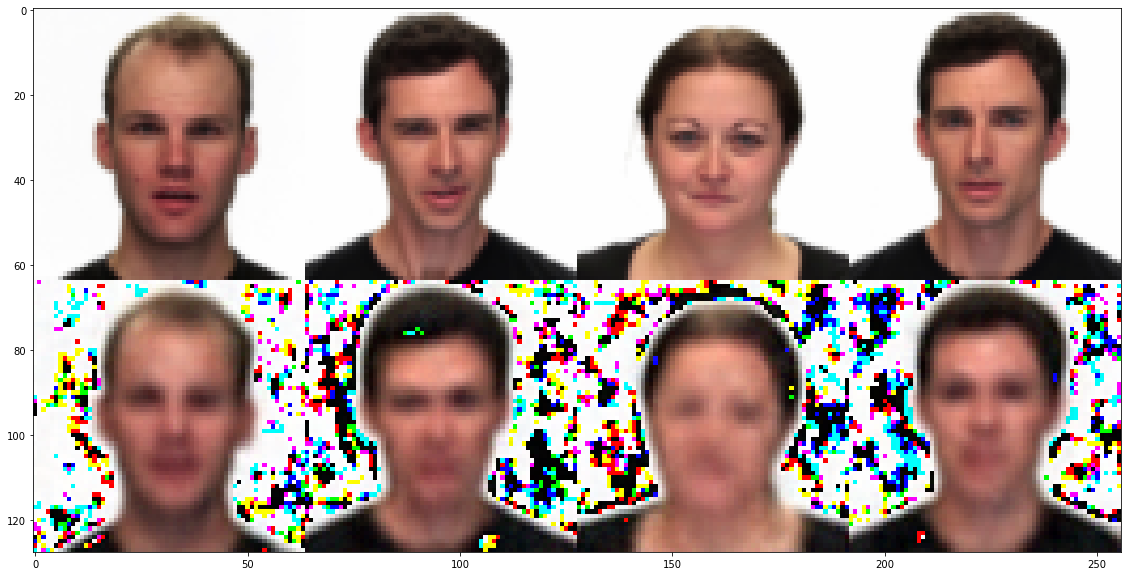

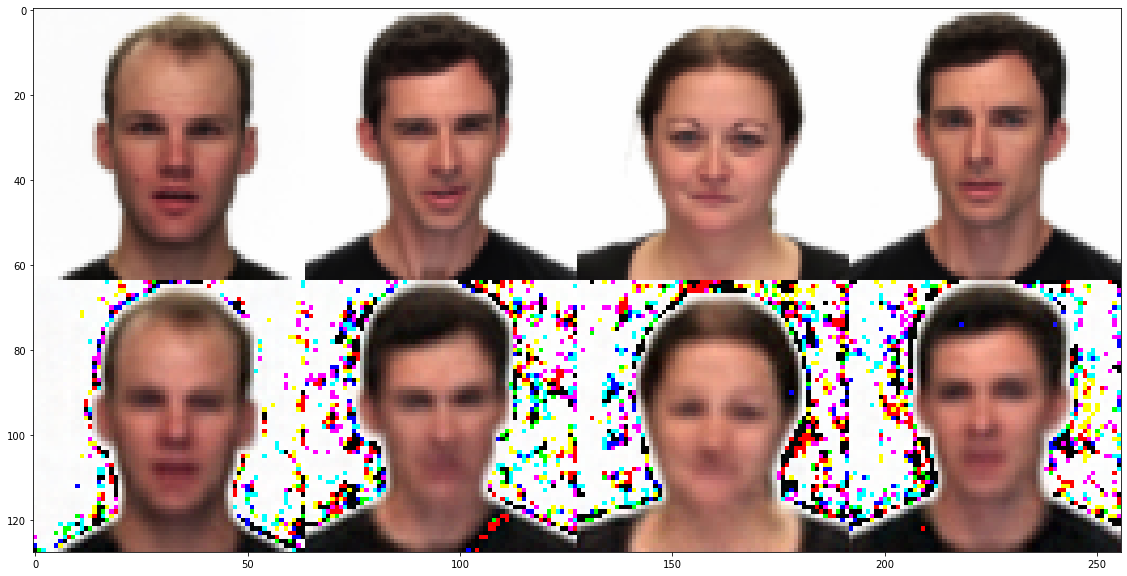

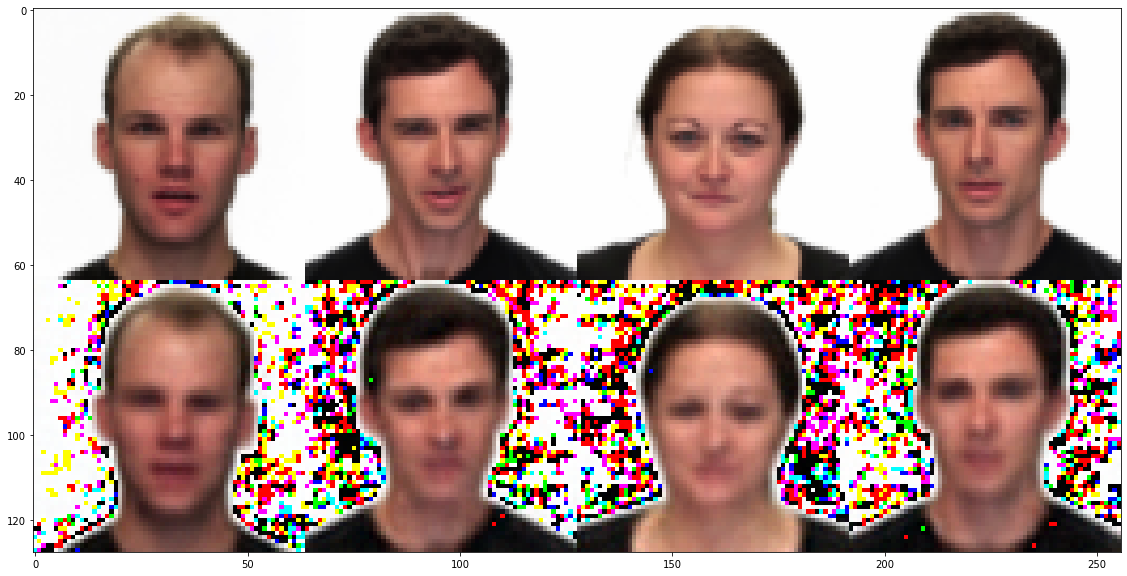

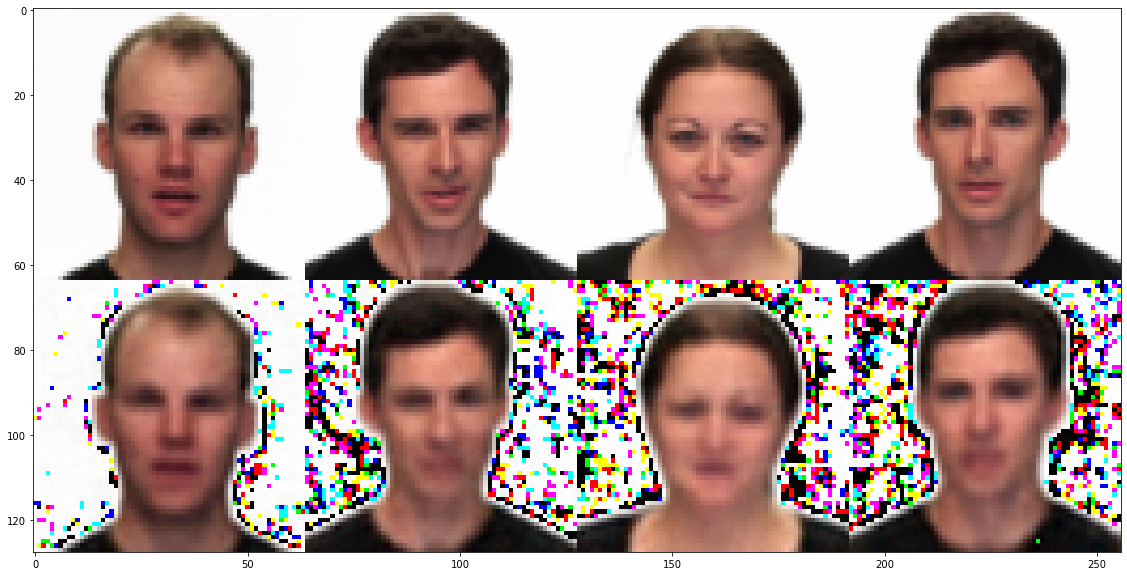

In [9]:
folder_path = "../trained_models/"

model_names = ["ravdess_InfoVAE_13_moe.save",
               "ravdess_InfoVAE_14_moe.save",
               "ravdess_InfoVAE_15_moe.save",
               "ravdess_InfoVAE_16_moe.save",
               "ravdess_InfoVAE_17_moe.save",
               "ravdess_InfoVAE_18_moe.save",
               "ravdess_InfoVAE_19_moe.save",
               "ravdess_InfoVAE_21_moe.save",
               "ravdess_InfoVAE_22_moe.save",
               "ravdess_InfoVAE_23_moe.save",
               "ravdess_InfoVAE_24_moe.save",
               "ravdess_InfoVAE_25_moe.save",
               "ravdess_InfoVAE_26_moe.save",
               "ravdess_InfoVAE_27_moe.save",
              ]


model_names = ["ravdess_InfoVAE_face_01.save",
               "ravdess_InfoVAE_face_02.save",
               "ravdess_InfoVAE_face_03.save",
               "ravdess_InfoVAE_face_04.save",
              ]

for model_name in model_names:
    loaded_data = torch.load(folder_path + model_name)
    model_args = loaded_data['model_args']
    train_args = loaded_data['train_args']
    losses = loaded_data['training_loss']
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    U.test_batch(model, testset_loader, num_images=4, model_eval=True)
    
    #U.print_losses(losses, model_name)
    #img = U.display_recontructed_images(model, model_eval=True)
    
    print(model_name)
    print(model_args)
    print(train_args)